In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Đường dẫn tới dữ liệu
train_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/train'
test_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2230 images belonging to 2 classes.
Found 857 images belonging to 2 classes.


In [ ]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
import tensorflow as tf

# Dùng ResNet50 bỏ phần FC
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Hàm trích xuất đặc trưng
def extract_features(generator, model):
    features = []
    labels = []
    generator.reset()
    for _ in tqdm(range(len(generator))):
        x_batch, y_batch = next(generator)
        batch_features = model.predict(x_batch, verbose=0)
        features.append(batch_features)
        labels.append(y_batch)
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_gen, feature_extractor)
X_test, y_test = extract_features(test_gen, feature_extractor)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 27/27 [07:28<00:00, 16.61s/it]


In [ ]:
#mất cân bằng dữ liệu
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
#huấn luyện mô hình
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

[Classification Report]
              precision    recall  f1-score   support

        fake       0.44      0.16      0.23       157
        real       0.83      0.95      0.89       700

    accuracy                           0.81       857
   macro avg       0.64      0.56      0.56       857
weighted avg       0.76      0.81      0.77       857

[Confusion Matrix]


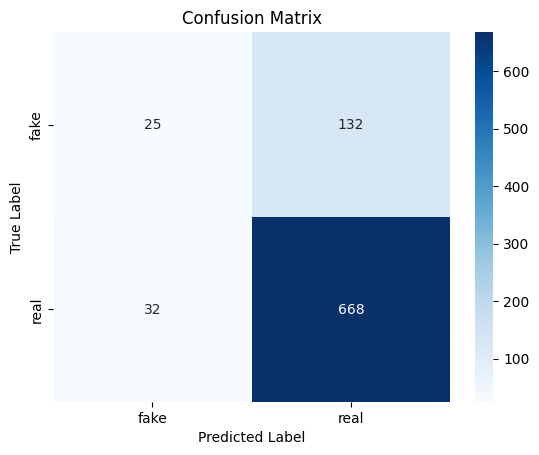

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("[Classification Report]")
print(classification_report(y_test, y_pred, target_names=["fake", "real"]))

print("[Confusion Matrix]")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["fake", "real"], yticklabels=["fake", "real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


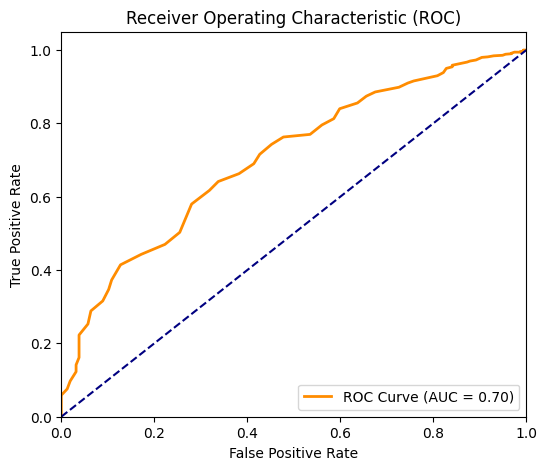

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
